# Prep
I do the following prep steps in order to get the data ready for some EDA steps.
- Import modules to use in later stages
- Set pathing for the data, then import the table
- Remove N/A Values and print DTypes for troubleshooting if needed
- Encode the Claim column to Yes = 1 and No = 0
- Print Unique values to check for errornous duplicates (i.e Friday and Fri showing as uniques means I need to adjust all values to one or the other)
- Get a list of all of the Numerical and Categorical columns.

In [81]:
import pandas as pd, numpy as np, torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from pathlib import Path
import matplotlib.pyplot as plt

base_path = Path()
travel_data = base_path.joinpath('travel_insurance.csv')
travel_df = pd.read_csv(travel_data)
travel_df.dropna(inplace=True)
display(travel_df.head())
print(travel_df.dtypes)

,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Gender,Age
0,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,81
1,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,71
5,JZI,Airlines,Online,Value Plan,No,66,UNITED STATES,-121.0,42.35,F,44
11,JZI,Airlines,Online,Basic Plan,No,1,MALAYSIA,-18.0,6.30,M,47
12,KML,Travel Agency,Online,Premier Plan,No,53,NORWAY,-130.0,49.40,F,48


Agency                   object
Agency Type              object
Distribution Channel     object
Product Name             object
Claim                    object
Duration                  int64
Destination              object
Net Sales               float64
Commision (in value)    float64
Gender                   object
Age                       int64
dtype: object


In [82]:
pred_series = travel_df["Claim"].apply(lambda x: 1 if x == 'Yes' else 0)
scaling_df = travel_df.drop(columns=["Claim"])

In [83]:
numeric_cols = []
categorical_cols = []
for col in scaling_df.columns:
    if scaling_df[col].dtype == 'object':
        categorical_cols.append(col)
        print(col, scaling_df[col].unique())
    else:
        numeric_cols.append(col)

Agency ['CBH' 'JZI' 'KML' 'C2B' 'JWT' 'RAB' 'ART' 'CSR' 'CCR' 'ADM' 'CWT' 'LWC'
 'TTW' 'TST']
Agency Type ['Travel Agency' 'Airlines']
Distribution Channel ['Offline' 'Online']
Product Name ['Comprehensive Plan' 'Value Plan' 'Basic Plan' 'Premier Plan'
 'Bronze Plan' 'Silver Plan' 'Annual Silver Plan' '24 Protect' 'Gold Plan'
 'Annual Gold Plan' 'Rental Vehicle Excess Insurance'
 'Single Trip Travel Protect Silver' 'Individual Comprehensive Plan'
 'Spouse or Parents Comprehensive Plan' 'Annual Travel Protect Silver'
 'Single Trip Travel Protect Platinum' 'Annual Travel Protect Gold'
 'Single Trip Travel Protect Gold' 'Annual Travel Protect Platinum'
 'Child Comprehensive Plan' 'Travel Cruise Protect'
 'Travel Cruise Protect Family']
Destination ['MALAYSIA' 'UNITED STATES' 'NORWAY' 'SINGAPORE' 'INDIA'
 'BRUNEI DARUSSALAM' 'AUSTRALIA' 'INDONESIA' 'THAILAND' 'CHINA'
 'PHILIPPINES' 'HONG KONG' 'VIET NAM' 'CAMBODIA' 'AUSTRIA' 'MYANMAR'
 'JAPAN' 'TAIWAN, PROVINCE OF CHINA' 'SRI LANKA' 'UNITE

# Encoding
I take the list of categorical columns and ordinal encode them. Then I scale the numerical column to a standard distribution range - though it didn't make a difference in the performance of the model, it is still best practice. Finally I add in the claim column to join our formatted dataset.

In [99]:
scaling_df[categorical_cols] = OrdinalEncoder().fit_transform(scaling_df[categorical_cols])
scaling_df[numeric_cols] = StandardScaler().fit_transform(scaling_df[numeric_cols])
scaling_df["Claim"] = pred_series
display(scaling_df.head())

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Gender,Age,Claim
0,3.0,1.0,0.0,9.0,1.038213,43.0,-1.170622,-0.356954,0.0,1.733272,0
1,3.0,1.0,0.0,9.0,1.038213,43.0,-1.170622,-0.356954,0.0,1.254660,0
5,8.0,0.0,1.0,21.0,-0.023974,79.0,-2.415836,0.956221,0.0,-0.037592,0
11,8.0,0.0,1.0,6.0,-0.599326,43.0,-1.021737,-0.487951,1.0,0.105991,0
12,9.0,1.0,1.0,12.0,-0.139045,56.0,-2.537650,1.238646,0.0,0.153853,0


# Creating the dataset
Similar to most of the exercises, we have some pretty basic data that doesn't need complex processing at this point (such as building a vocab) so I create a simple ClaimDataset subclass that extracts the related values. I couldn't think of a name for the non-claim data, so I just stuck with the X constant value. 

Next I performed the train-test splits, created the dataset, then loaded it up into the dataloader. 

In [100]:
class ClaimDataset(Dataset):
    def __init__(self, data):
        self.X = data.drop("Claim", axis=1).values
        self.claim = data['Claim'].values
        
        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.claim = torch.tensor(self.claim, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.claim[idx]

In [101]:
test_data, train_data = train_test_split(scaling_df, test_size=0.2, random_state=42)

train_dataset = ClaimDataset(train_data)
test_dataset = ClaimDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Defining the model
This model has been a sort of a staple in this class for me. Its served as the back-bone of most of my models, and in this case served well with just a minor tweak. I adjusted the output to round a torch.sigmoid function to 0 or 1. The logic is sort of like this:

- FC1 takes in the input then scales up the inputs to various coeffecients at the hidden_size (in our case 64). 
- RELU resets any negative values to 0
- FC2 takes the hidden layer and creates a guess from it
- Next we get the sigmoid of this guess. In a sense it casts the value to a range of 0 to 1, which results in effectively a probability that the data results in a claim (or 1 in this case). We then subtract 0.4999 as a threshold value.
- We then round this value to get our true guess of 0 or 1.

In [224]:
class ClaimPredictor(nn.Module):

    torch.manual_seed(42)
    
    def __init__(self, input_size, hidden_size, output_size):
        super(ClaimPredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = (torch.sigmoid(out)-0.4999)
        out = torch.round(out)
        return out

# Train/Test
Finally we train the model. I get the input size, and set the other hyperparamaters. 
The critical part in this assignment was finding the appropriate loss function. Initially I tried MSELoss with poor results, and both variations of BCE loss with even worse results (BCELoss and BCELossWithLogits). 
With these loss functions the accuracy ranged between 3% and 29%. Once I tried CrossEntropyLoss, the Accuracy instantly spiked up to 94%. Some slight adjustments to Epochs, Hidden Size, and Optimizer type netted an accuracy of 96%. After further look at this though, I found the reason was due to predicting only one value. After some tweaking of a threshold value of -0.4999 I was able to have reasonably accurate guesses for both catagorical labels (at ~83%). I should certainly find a better way to both find the threshold value, and predict these with better accuracy.

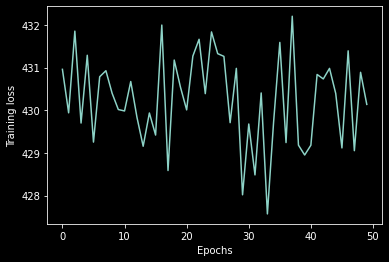

In [225]:
# Define the model parameters
input_size = train_dataset.X.shape[1]
hidden_size = 64
output_size = 1
lr = 0.001
epochs = 50

# Instantiate the model and the optimizer
model = ClaimPredictor(input_size, hidden_size, output_size)
optimizer = optim.Adagrad(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

loss_data = []
# Train the model
model.train()
for epoch in range(epochs):
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    loss_data.append(train_loss)

plt.plot(range(epochs), loss_data)
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.show()

pred_df = pd.DataFrame()
# Evaluate the model
model.eval()
with torch.no_grad():
    test_loss = 0
    for X_batch, y_batch in test_loader:
        y_pred_test = model(X_batch)
        test_loss += criterion(y_pred_test.squeeze(), y_batch).item()
        X_batch = X_batch.numpy()
        y_batch = y_batch.numpy()
        y_pred_test = y_pred_test.detach().numpy()

        # Extract the data from the tensors
        X_batch_df = pd.DataFrame(X_batch, columns=test_data.drop("Claim", axis=1).columns)
        y_batch_df = pd.DataFrame(y_batch, columns=["Claim"])
        y_pred_test_df = pd.DataFrame(y_pred_test, columns=["Predicted Claim"])

        # Concatenate the dataframes
        pred_df = pd.concat([pred_df, pd.concat([X_batch_df, y_batch_df, y_pred_test_df], axis=1)], axis=0)
        

In [228]:
from sklearn.metrics import confusion_matrix, classification_report
display(pred_df)
print(confusion_matrix(pred_df['Claim'], pred_df['Predicted Claim']))
print(classification_report(pred_df['Claim'], pred_df['Predicted Claim']))

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Gender,Age,Claim,Predicted Claim
0,8.0,0.0,1.0,6.0,-0.059381,43.0,-0.480340,-0.431867,1.0,-0.468343,0.0,0.0
1,8.0,0.0,1.0,6.0,0.223869,15.0,-0.020152,0.044850,1.0,-0.085453,0.0,0.0
2,2.0,0.0,1.0,7.0,-0.537365,67.0,-0.412665,-0.469924,1.0,-0.755510,0.0,0.0
3,10.0,1.0,1.0,16.0,-0.218709,74.0,-0.426200,-0.063313,0.0,0.776048,0.0,1.0
4,8.0,0.0,1.0,6.0,-0.519662,74.0,-0.480340,-0.431867,1.0,-0.037592,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
10,10.0,1.0,1.0,17.0,-0.369185,9.0,-0.138583,0.489920,0.0,-0.659788,0.0,0.0
11,7.0,0.0,1.0,21.0,-0.528513,30.0,-0.101362,0.060874,0.0,3.504137,0.0,0.0
12,11.0,0.0,1.0,21.0,-0.563919,11.0,-0.575084,-0.499969,1.0,-0.420482,0.0,0.0
13,8.0,0.0,1.0,21.0,1.038213,69.0,0.913759,1.012306,1.0,0.776048,0.0,1.0


[[12035  2019]
 [  492    29]]
              precision    recall  f1-score   support

         0.0       0.96      0.86      0.91     14054
         1.0       0.01      0.06      0.02       521

    accuracy                           0.83     14575
   macro avg       0.49      0.46      0.46     14575
weighted avg       0.93      0.83      0.87     14575



# Conclusion
This was a great assignment for me to learn about imbalanced classes and how it impacts the model performance. The treshold value I had to use to get multiple predictions was drastically high, and I can't help but wonder if mixing the data such that I had at least 80% of each label in the training set would have helped - or if there was a better way to go about it. I'm content with 83% accuracy for this model, and hope to reach around that (or higher) with my Term Project.